Ce code définit un environnement de `gymn` appelé `BusEnv` pour un problème d'apprentissage par renforcement. L'environnement est basé sur un réseau de rues, et l'objectif de l'agent est de faire naviguer un bus à travers le réseau et de prendre et déposer des passagers aux arrêts de bus.

L'environnement est défini à l'aide de la bibliothèque OpenAI gym et des bibliothèques OSMnx et NetworkX pour travailler avec les données du réseau routier.

L'environnement prend les paramètres suivants lorsqu'il est initialisé :

- area_name : Une chaîne de caractères indiquant le nom de la ville ou de la région pour laquelle les données du réseau routier doivent être chargées (la valeur par défaut est 'Toulouse').
- start_node : L'ID du nœud de départ du bus dans le réseau de rues (par défaut, aucun).
- end_node : L'ID du nœud de fin du bus dans le réseau de rues (par défaut, il s'agit d'un nœud nul).
- area_point : Un tuple de coordonnées de latitude et de longitude représentant un point central pour le réseau de rues (par défaut : aucun).
- area_distance : Un flotteur représentant le rayon en mètres autour du point central pour lequel les données du réseau de rues doivent être chargées (par défaut, il n'y en a pas).

La méthode `_create_graph` est utilisée pour charger les données du réseau de rues pour la zone donnée, soit par nom, soit par point et distance. La méthode charge le réseau à l'aide des données OSM, le convertit en un graphe orienté, ajoute les limitations de vitesse et les temps de parcours comme attributs d'arête, et ajoute 100 arrêts de bus au graphe à des emplacements aléatoires.

La méthode reset réinitialise l'environnement à son état initial, met les drapeaux `passenger_on` et `passenger_off` à False, choisit des nœuds de départ et d'arrivée aléatoires parmi les arrêts de bus du graphe et renvoie l'observation initiale.

La méthode `_get_observation` calcule la distance jusqu'au prochain arrêt de bus en utilisant la méthode `shortest_path_length` de NetworkX et renvoie un dictionnaire contenant l'état actuel de l'environnement, y compris les drapeaux `passenger_on` et `passenger_off` et la `distance_to_stop`.

La méthode `step` prend une action en entrée, soit 0 (ne rien faire), soit 1 (s'arrêter au prochain arrêt de bus). Si l'action est 1 et que le nœud actuel est un arrêt de bus, les drapeaux `passenger_on` et `passenger_off` sont mis à True. La récompense est calculée en fonction de l'état de l'environnement. Une récompense positive de 10 est attribuée si les indicateurs `passager_on` et `passager_off` sont tous deux à True, et une récompense négative de -1 est attribuée dans le cas contraire. Le drapeau `done` est mis à Vrai si le bus a atteint le nœud final. Enfin, la méthode déplace le bus vers le nœud suivant et renvoie le nouvel état, la récompense, done et un dictionnaire d'informations vide.

Dans l'ensemble, ce code définit un environnement de `gymn` pour un problème d'apprentissage par renforcement où l'agent doit faire naviguer un bus dans un réseau de rues et prendre et déposer des passagers aux arrêts de bus.

https://www.datacamp.com/tutorial/networkx-python-graph-tutorial

# Install

In [1]:
!pip install gymnasium
!pip install osmnx
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.6 MB/s eta 0:00:00


# Graph : quartier Compans-Caffarelli

[Analyse du graphe](https://notebook.community/gboeing/urban-data-science/21-Urban-Street-Networks/01-osmnx-overview)

[Analyse graphe 1.3 (normalement)](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)

[Github examples osmnx](https://github.com/gboeing/osmnx-examples/tree/v0.13.0)

[Autre tuto](https://deepnote.com/@sookyan-siew/Python-Retrieving-OpenStreetMap-data-with-OSMNX-34816147-fcc0-4509-b68d-8a9c72d3f986)

[Tuto 2](https://www.codeproject.com/Articles/5328791/Using-OSMnx-for-Graph-Analysis-of-Street-Networks)

## Import

In [ ]:
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)

## Temps et vitesse

In [ ]:
Compans = (43.61,1.43)
G = ox.graph_from_point(Compans, dist=1000, network_type='drive', simplify=True)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

In [ ]:
gdf_edges = ox.graph_to_gdfs(G, nodes=False)
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])
center_point = gdf_edges.unary_union.centroid.coords[0]

print(f""" lngs : {lngs} lats : {lats} center_point : {center_point}""")

In [ ]:
center_node = ox.nearest_nodes(G, center_point[0],center_point[1])
nearest_nodes = ox.nearest_nodes(G, lngs, lats)
nearest_edge = ox.nearest_edges(G, center_point[0],center_point[1])
nearest_edges = ox.nearest_edges(G, lngs, lats)

print(f""" center_node : {center_node} nearest_nodes : {nearest_nodes}
nearest_edge : {nearest_edge} nearest_edges : {nearest_edges} """)

In [ ]:
route = nx.shortest_path(G, 226138356, 243287152, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [ ]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

In [ ]:
route1 = nx.shortest_path(G, 226138356, 243287152, weight='length')
route2 = nx.shortest_path(G, 7376442687, 7950674961, weight='travel_time')

In [ ]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 1446 meters and takes 189 seconds.
Route 2 is 460 meters and takes 47 seconds.


In [ ]:
# pick route colors
c1 = 'r' #length
c2 = 'b' #travel_time
rc1 = [c1] * (len(route1) - 1)
rc2 = [c2] * (len(route2) - 1)
rc = rc1 + rc2
nc = [c1, c2]

# plot the routes
fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, route_linewidth=6, route_colors=nc, node_size=0, bgcolor='k')

## Plot détaillé

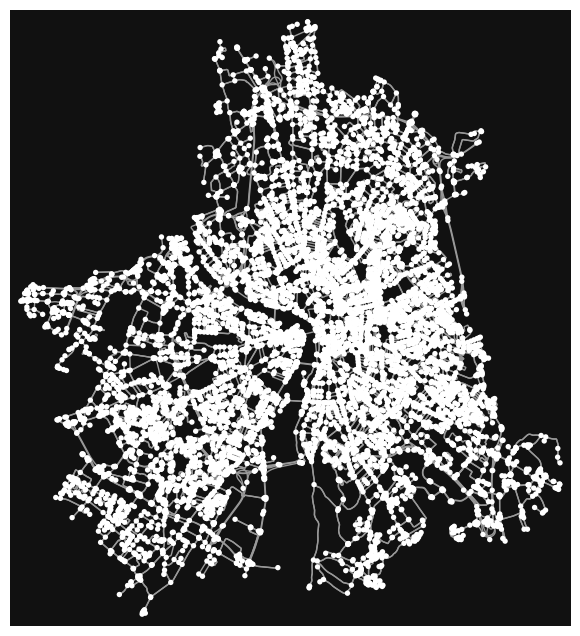

In [ ]:
G = ox.graph_from_place('Toulouse', network_type='drive', simplify=True)
fig, ax = ox.plot_graph(G)

In [ ]:
area = ox.geocode_to_gdf('Toulouse')
type(area)

geopandas.geodataframe.GeoDataFrame

In [ ]:
area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((1.35040 43.60427, 1.35164 43.60390, ...",43.668708,43.532654,1.51538,1.350396,297913876,relation,35738,43.604462,1.444247,"Toulouse, Haute-Garonne, Occitania, Metropolit...",boundary,administrative,0.778214


In [ ]:
buildings = ox.geometries_from_place('Toulouse', tags={'building':True})

In [ ]:
len(buildings)

133715

In [ ]:
restaurants = ox.geometries_from_place('Toulouse',
                                  tags={"amenity": "restaurant"}
                                 )

In [ ]:
nodes, edges = ox.graph_to_gdfs(G)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nodes.head()

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
625236,43.555496,1.472247,turning_circle,1,NaN,POINT (1.47225 43.55550)
625239,43.554530,1.470092,NaN,1,NaN,POINT (1.47009 43.55453)
625240,43.554446,1.471476,NaN,3,NaN,POINT (1.47148 43.55445)
625241,43.555052,1.470920,NaN,1,NaN,POINT (1.47092 43.55505)
625242,43.555058,1.471933,NaN,3,NaN,POINT (1.47193 43.55506)


In [ ]:
edges.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


osmid                     name      highway  \
u      v          key                                                    
625236 625242     0     79568771  Allée des Grands Chênes  residential   
625239 625240     0    148524229       Impasse des Hêtres  residential   
625240 625242     0     79568771  Allée des Grands Chênes  residential   
       1378882319 0     79568771  Allée des Grands Chênes  residential   
       625239     0    148524229       Impasse des Hêtres  residential   

                       oneway reversed   length  \
u      v          key                             
625236 625242     0     False     True   54.951   
625239 625240     0     False    False  112.414   
625240 625242     0     False    False   77.433   
       1378882319 0     False     True   56.988   
       625239     0     False     True  112.414   

                                                                geometry  \
u      v          key                                                      
625236 625242     0    LINESTRING (1.47225 43.55550, 1.47213 43.55531...   
625239 625240     0    LINESTRING (1.47009 43.55453, 1.47067 43.55447...   
625240 625242     0    LINESTRING (1.47148 43.55445, 1.47156 43.55455...   
       1378882319 0    LINESTRING (1.47148 43.55445, 1.47142 43.55437...   
       625239     0    LINESTRING (1.47148 43.55445, 1.47143 43.55446...   

                      junction lanes  ref maxspeed tunnel bridge width access  \
u      v          key                                                           
625236 625242     0        NaN   NaN  NaN      NaN    NaN    NaN   NaN    NaN   
625239 625240     0        NaN   NaN  NaN      NaN    NaN    NaN   NaN    NaN   
625240 625242     0        NaN   NaN  NaN      NaN    NaN    NaN   NaN    NaN   
       1378882319 0        NaN   NaN  NaN      NaN    NaN    NaN   NaN    NaN   
       625239     0        NaN   NaN  NaN      NaN    NaN    NaN   NaN    NaN   

                      est_width service  
u      v          key                    
625236 625242     0         NaN     NaN  
625239 625240     0         NaN     NaN  
625240 625242     0         NaN     NaN  
       1378882319 0         NaN     NaN  
       625239     0         NaN     NaN

<Axes: >

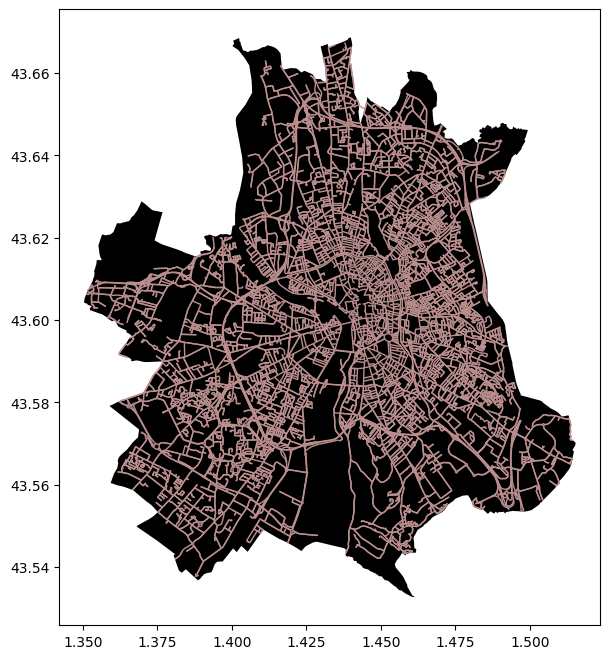

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot the footprint
area.plot(ax=ax, facecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')

<Axes: >

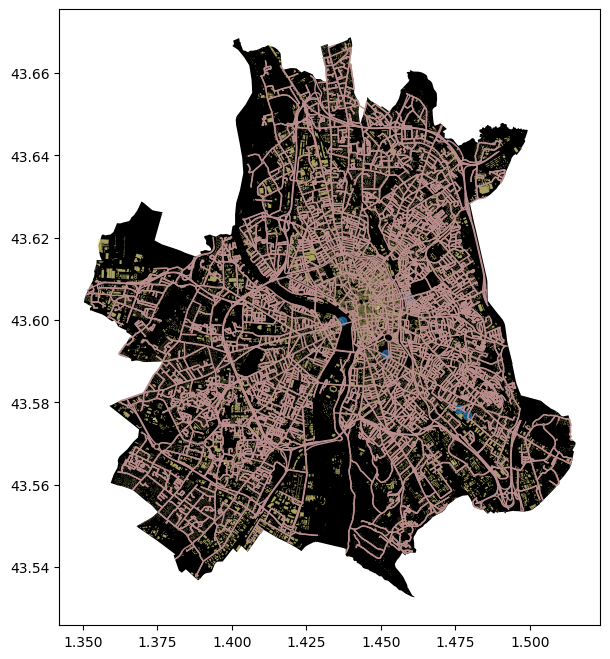

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot the footprint
area.plot(ax=ax, facecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')

# Plot buildings
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)

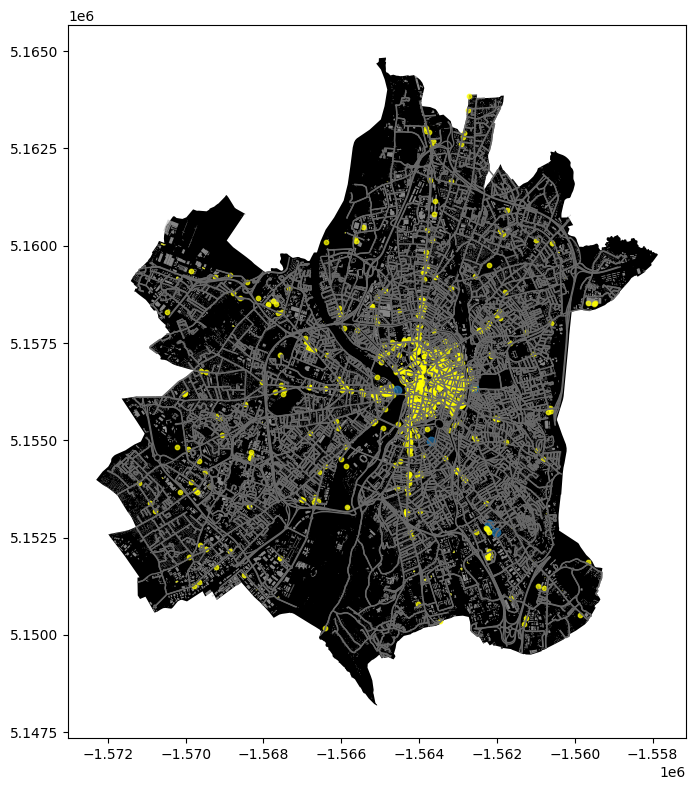

In [ ]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layers
area = area.to_crs(projection)
edges = edges.to_crs(projection)
buildings = buildings.to_crs(projection)
restaurants = restaurants.to_crs(projection)
# Create a new plot with the re-projected layers:

fig, ax = plt.subplots(figsize=(12,8))

# Plot the footprint
area.plot(ax=ax, facecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')

# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)

# Plot restaurants
restaurants.plot(ax=ax, color='yellow', alpha=0.7, markersize=10)
plt.tight_layout()

In [ ]:
leisure = ox.geometries_from_place('Toulouse', tags={'leisure':True})
leisure.head(3)

email  \
element_type osmid                                             
node         27502542   port-saintsauveur@mairie-toulouse.fr   
             367034690                                   NaN   
             440009184                                   NaN   

                                      fax harbour harbour:bottle_gas  \
element_type osmid                                                     
node         27502542   +33 5 61 48 11 41     yes                yes   
             367034690                NaN     NaN                NaN   
             440009184                NaN     NaN                NaN   

                       harbour:doctor harbour:electricity  \
element_type osmid                                          
node         27502542             yes                 yes   
             367034690            NaN                 NaN   
             440009184            NaN                 NaN   

                       harbour:fuel_station harbour:laundrette  \
element_type osmid                                               
node         27502542                   yes                yes   
             367034690                  NaN                NaN   
             440009184                  NaN                NaN   

                       harbour:pharmacy harbour:provisions  ...  \
element_type osmid                                          ...   
node         27502542               yes                yes  ...   
             367034690              NaN                NaN  ...   
             440009184              NaN                NaN  ...   

                       service:lasercutter baby heating ways boundary  \
element_type osmid                                                      
node         27502542                  NaN  NaN     NaN  NaN      NaN   
             367034690                 NaN  NaN     NaN  NaN      NaN   
             440009184                 NaN  NaN     NaN  NaN      NaN   

                       protect_class protection_title ref:FR:INPN valid_from  \
element_type osmid                                                             
node         27502542            NaN              NaN         NaN        NaN   
             367034690           NaN              NaN         NaN        NaN   
             440009184           NaN              NaN         NaN        NaN   

                       year_import  
element_type osmid                  
node         27502542          NaN  
             367034690         NaN  
             440009184         NaN  

[3 rows x 173 columns]

In [ ]:
leisure["leisure"].value_counts()

swimming_pool       3047
pitch                737
playground           256
park                 191
picnic_table         181
sports_centre        105
garden                73
track                 72
fitness_centre        54
dance                 36
fitness_station       33
dog_park              16
outdoor_seating       10
escape_game            9
hackerspace            8
stadium                5
slipway                4
bandstand              3
nature_reserve         3
ice_rink               2
horse_riding           2
spa                    2
sports_hall            2
bowling_alley          2
trampoline_park        2
sauna                  2
golf_course            1
common                 1
marina                 1
amusement_arcade       1
indoor_play            1
laser                  1
bleachers              1
Name: leisure, dtype: int64

<Axes: >

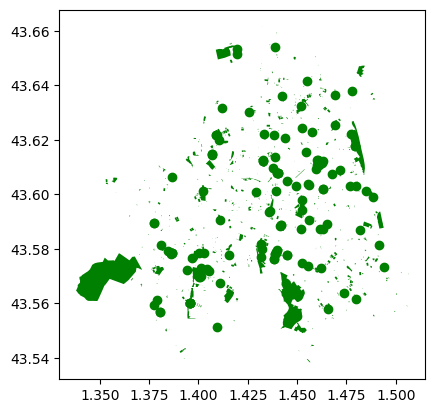

In [ ]:
parks = leisure[leisure["leisure"].isin(["pitch","park","playground","garden"])]
parks.plot(color="green")

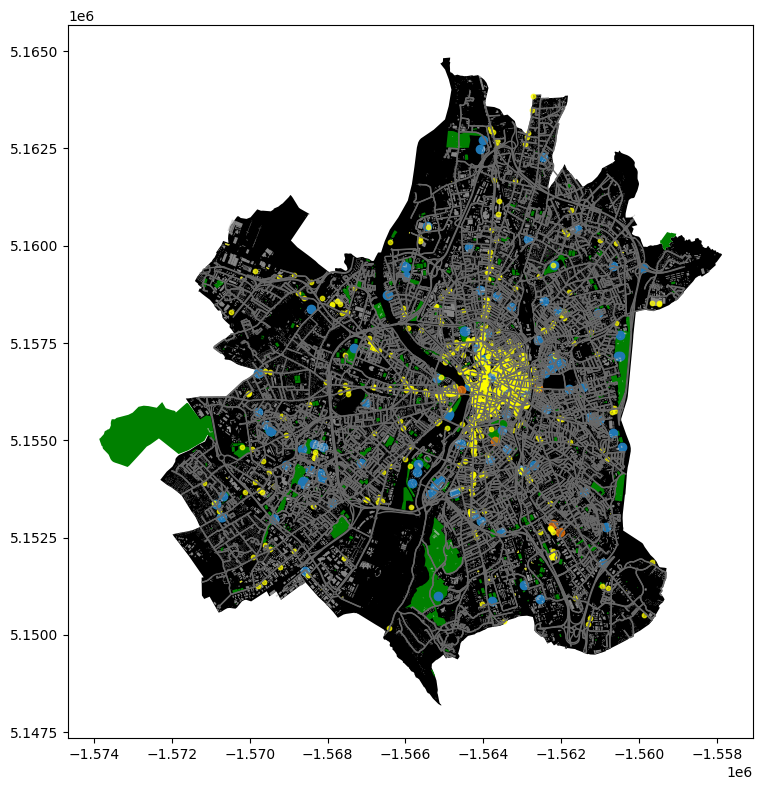

In [ ]:
parks = parks.to_crs(projection)
fig, ax = plt.subplots(figsize=(12,8))

# Plot the footprint
area.plot(ax=ax, facecolor='black')

# Plot the parks
parks.plot(ax=ax, facecolor="green")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')

# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)

# Plot restaurants
restaurants.plot(ax=ax, color='yellow', alpha=0.7, markersize=10)
plt.tight_layout()

# Grille

[Graph exploration](https://github.com/w00zie/graph_exploration)

[From adjacency -> graph](https://medium.com/analytics-vidhya/graphs-in-python-adjacency-matrix-d0726620e8d7)

[Implement graph](https://www.educative.io/answers/how-to-implement-a-graph-in-python)

# DQN

[Pytorch DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

[Graph exploration](https://github.com/w00zie/graph_exploration)

# BusEnv

In [ ]:
import itertools
import gym
from gym import spaces
import networkx as nx
import torch
from torch_geometric.data import Data
import numpy as np

class BusEnv(gym.Env):
  def __init__(self, path_to_map, fixed_start_node=False):

        # Get the adjacency matrix and the obstacles list
        state = np.load(path_to_map)
        self.adj, self.obstacles = state[0], state[1].nonzero()[0]

        # Construct networkx graph
        self.G = nx.from_numpy_matrix(self.adj)
        self.n_nodes = self.adj.shape[0]
        self.valid_nodes = [n for n in range(self.n_nodes) if n not in self.obstacles]

        # Construct data (required by torch_geometric)
        self.edge_index = torch.tensor(self.adj.nonzero(), dtype=torch.long)
        self.grid_size = int(np.sqrt(self.n_nodes))
        self.pos = torch.tensor(list(itertools.product(range(self.grid_size), range(self.grid_size))))
        self.data = self.build_data()
        self.fixed_start_node = fixed_start_node

        # Observation space is the discrete space of all nodes
        self.observation_space = spaces.Discrete(self.n_nodes)
        # Action space is (0:Left, 1:Up, 2:Right, 3:Down)
        self.action_space = spaces.Discrete(4)


## Sauvegarde

In [ ]:
class BusEnv(gym.Env):
    def __init__(self, area_name='Toulouse', start_node=None, end_node=None, area_point=None, area_distance=None):
        self.area_name = area_name
        self.graph = self._create_graph(area_name, area_point, area_distance)
        self.start_node = start_node
        self.end_node = end_node
        self.passenger_on = False
        self.passenger_off = False

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Dict({
            'passenger_on': spaces.Discrete(2),
            'passenger_off': spaces.Discrete(2),
            'distance_to_stop': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

    def _create_graph(self, area_name, area_point, area_distance):
        # Load the street network using OSM
        if area_point and area_distance is not None :
            G = ox.graph_from_point(area_point, dist=area_distance, network_type='drive')
        else :
            G = ox.graph_from_place(area_name, network_type='drive')

        # Convert the street network to a directed graph
        G = G.to_directed()
        # Add speed limits as edge attributes
        G = ox.add_edge_speeds(G)
        # Convert the speed limits to travel times as edge attributes
        G = ox.add_edge_travel_times(G)
        # Add bus stops as node attributes
        for node in random.sample(list(G.nodes()), k=100):
            G.nodes[node]['bus_stop'] = True
        return G

    def _get_observation(self):
        # Calculate the distance to the next stop
        distance_to_stop = nx.shortest_path_length(self.graph, source=self.start_node, target=self.end_node, weight='travel_time')
        return {'passenger_on': int(self.passenger_on), 'passenger_off': int(self.passenger_off), 'distance_to_stop': distance_to_stop}

    def _get_num_bus_stops(self):
        # Compter le nombre de bus_stop dans le graph
        num_bus_stops = 0
        for node in self.graph.nodes():
            if self.graph.nodes[node].get('bus_stop', False):
                num_bus_stops += 1
        return {'Nombre de bus_stop dans le graph ': int(num_bus_stops)}

    def _get_plot_graph(self):
        return ox.plot_graph(self.graph)

    def reset(self):
        # Reset the environment
        self.passenger_on = False
        self.passenger_off = False
        # Choose random start and end nodes
        self.start_node, self.end_node = np.random.choice(list(nx.get_node_attributes(self.graph, 'bus_stop').keys()), size=2, replace=False)
        # Return the initial observation
        return self._get_observation()

    def step(self, action):
        # Update the state of the environment based on the action taken by the agent
        if action == 0:  # Do nothing
            pass
        elif action == 1:  # Stop at the next bus stop
            if self.graph.nodes[self.start_node].get('bus_stop', False):
                self.passenger_on = True
                self.passenger_off = True
        # Calculate the reward based on the state of the environment
        if self.passenger_on and self.passenger_off:
            reward = 10
        else:
            reward = -1
        done = (self.start_node == self.end_node)
        # Move to the next node
        self.start_node = next(nx.neighbors(self.graph, self.start_node))
        # Return the new state, reward, and whether the episode is over
        return self._get_observation(), reward, done, {}

In [ ]:
#obs = env.reset()
#done = False
#while not done:
#    action = env.action_space.sample() # get the action from the agent
#   obs, reward, done, info = env.step(action)
#    print(obs, reward, done, info)
#env.close()

In [ ]:
# DQN

class QLearningAgent:


    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.01):

        # Initialiser la Q-table avec des zéros
        max_distance = 1000
        num_actions = env.action_space.n

        self.env = env
        self.q_table = np.zeros((max_distance + 1, num_actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            distance = int(state['distance_to_stop'])
            return np.argmax(self.q_table[distance])

    def train(self, num_episodes):
        rewards = []
        for i in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward
                distance = int(state['distance_to_stop'])
                next_distance = int(next_state['distance_to_stop'])
                q_value = self.q_table[distance][action]
                next_q_value = np.max(self.q_table[next_distance])
                td_error = reward + self.discount_factor * next_q_value - q_value
                self.q_table[distance][action] += self.learning_rate * td_error
                state = next_state
                if done:
                    break
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards.append(total_reward)
            print(f"Episode {i}: reward = {total_reward}, epsilon = {self.epsilon}")

# Exemple d'utilisation :
agent = QLearningAgent(env)
agent.train(num_episodes=1000)
